# Import Libraries

In [64]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker
import json

# Read data from DB

In [65]:
with open('../config/credentials.json', 'r') as json_file:
    data = json.load(json_file)
    host = data["host"]
    database = data["database"]
    user = data["user"]
    password = data["password"]

# Create Connection to DB
database_connection = f"postgresql://{user}:{password}@{host}/{database}"
engine = create_engine(database_connection)

Session = sessionmaker(bind=engine)
session = Session()
metadata = MetaData(bind=engine)
metadata.reflect()

grammys_table = metadata.tables['grammys_data']
grammys_records = session.query(grammys_table).all()
grammys_data = [record._asdict() for record in grammys_records]
df_grammys = pd.DataFrame(grammys_data)

session.close()

In [66]:
df=df_grammys
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


# EDA

In [67]:
df.describe()

,year,published_at,updated_at
count,4810.000000,4810,4810
mean,1995.566944,2018-02-27 05:58:30.454677248,2019-09-24 09:10:26.281496832
min,1958.000000,2017-11-28 03:03:45,2017-11-28 03:03:45
25%,1983.000000,2017-11-28 03:03:45,2019-09-10 03:06:59
50%,1998.000000,2017-11-28 03:03:45,2019-09-10 03:08:19
75%,2010.000000,2017-11-28 03:03:45,2019-09-10 03:11:09
max,2019.000000,2020-05-19 07:10:28,2020-09-01 14:16:40
std,17.149720,NaN,NaN


In [68]:
# Calculate NAs Percent
total_entries = len(df)
missing_per_column = df.isnull().sum()
percentage_missing = (missing_per_column / total_entries) * 100
percentage_missing

year            0.0
title           0.0
published_at    0.0
updated_at      0.0
category        0.0
nominee         0.0
artist          0.0
workers         0.0
img             0.0
winner          0.0
dtype: float64

In [69]:
df.replace('NaN', np.nan, inplace=True)

total_entries = len(df)
missing_per_column = df.isnull().sum()
percentage_missing = (missing_per_column / total_entries) * 100
percentage_missing

year             0.000000
title            0.000000
published_at     0.000000
updated_at       0.000000
category         0.000000
nominee          0.124740
artist          38.253638
workers         45.530146
img             28.419958
winner           0.000000
dtype: float64

It can be seen that "NaN" was saved as a string and not as a Null in the database
Due to the high percentage of nulls in the artist column, attempting to impute them could bias or provide incorrect information, especially using classic methodologies such as the median or mean. 

Since these are names of artists related to specific songs, imputing in this manner would corrupt the data. Therefore, it has been decided to work with them as Unregistered and perform analysis accordingly.

### Data Distribution

In [70]:
category_counts = df['year'].value_counts()
category_counts

year
2019    433
2007    111
2008    111
2006    110
2009    109
       ... 
1968     40
1962     39
1960     39
1959     35
1958     28
Name: count, Length: 62, dtype: int64

In [71]:
category_counts = df['category'].value_counts()
category_counts

category
Song Of The Year                                          70
Record Of The Year                                        69
Album Of The Year                                         66
Best Opera Recording                                      64
Best Album Notes                                          63
                                                          ..
Best Engineered Recording (Non-Classical)                  1
Best Contemporary Pop Vocal Performance, Female            1
Best Contemporary Pop Vocal Performance, Male              1
Best Contemporary Pop Performance - Vocal Duo Or Group     1
Best Classical Performance - Operatic Or Choral            1
Name: count, Length: 638, dtype: int64

In [72]:
category_counts = df['winner'].value_counts()
category_counts

winner
True    4810
Name: count, dtype: int64

It can be seen that the data are distributed across many categories, indicating that analysis will be difficult, therefore categorization or grouping of this data will be performed.

### Data Handling

Regular expressions are used, which facilitate the management and grouping of the data.

In [73]:
df['awards_group'] = df['category'].str.extract('^(Song Of The Year|Record Of The Year|Album Of The Year)')
df.loc[df['category'].str.startswith('Best'), 'awards_group'] = 'Excellence Awards'
df['awards_group'] = df['awards_group'].fillna('Excellence Awards')


In [74]:
df['year_from_title'] = df['title'].str.extract('(\d{4})').astype(int)

bins = [1957, 1970, 1999, 2019]
labels = ['(1958-1970) AGM', '(1971-1999) AGM', '(2000-2019) AGM']

df['title_by_year'] = pd.cut(df['year_from_title'], bins=bins, labels=labels, right=True)
df.drop('year_from_title', axis=1, inplace=True)

In [75]:
df.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner,awards_group,title_by_year
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True,Record Of The Year,(2000-2019) AGM
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True,Record Of The Year,(2000-2019) AGM
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True,Record Of The Year,(2000-2019) AGM
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True,Record Of The Year,(2000-2019) AGM
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 07:10:28,2020-05-19 07:10:28,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True,Record Of The Year,(2000-2019) AGM


With the grouping, it was easier to analyze and select the most relevant columns of the dataset.

Which were "nominee", "artist", "winner", "awards_group", "title_by_year", giving us a clearer view of the data. Also, these columns were selected because they provide the most relevant data for future analysis.

In [76]:
# Drop Unselected Columns
df.drop(['img', 'workers', 'published_at', 'updated_at','year','title','category'], axis=1, inplace=True)
df.head()

,nominee,artist,winner,awards_group,title_by_year
0,Bad Guy,Billie Eilish,True,Record Of The Year,(2000-2019) AGM
1,"Hey, Ma",Bon Iver,True,Record Of The Year,(2000-2019) AGM
2,7 rings,Ariana Grande,True,Record Of The Year,(2000-2019) AGM
3,Hard Place,H.E.R.,True,Record Of The Year,(2000-2019) AGM
4,Talk,Khalid,True,Record Of The Year,(2000-2019) AGM


### Graphs

C:\Users\juanj\AppData\Local\Temp\ipykernel_18672\805685831.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nominations_by_category = df.groupby(['title_by_year', 'awards_group']).size().unstack(fill_value=0)


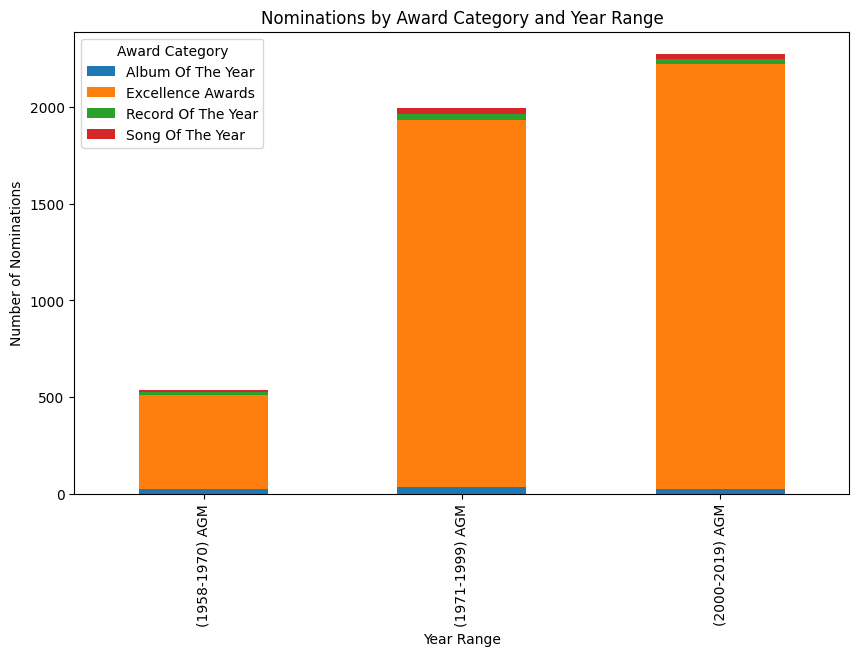

In [77]:
nominations_by_category = df.groupby(['title_by_year', 'awards_group']).size().unstack(fill_value=0)

# Graficar
nominations_by_category.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nominations by Award Category and Year Range')
plt.ylabel('Number of Nominations')
plt.xlabel('Year Range')
plt.legend(title='Award Category')
plt.show()

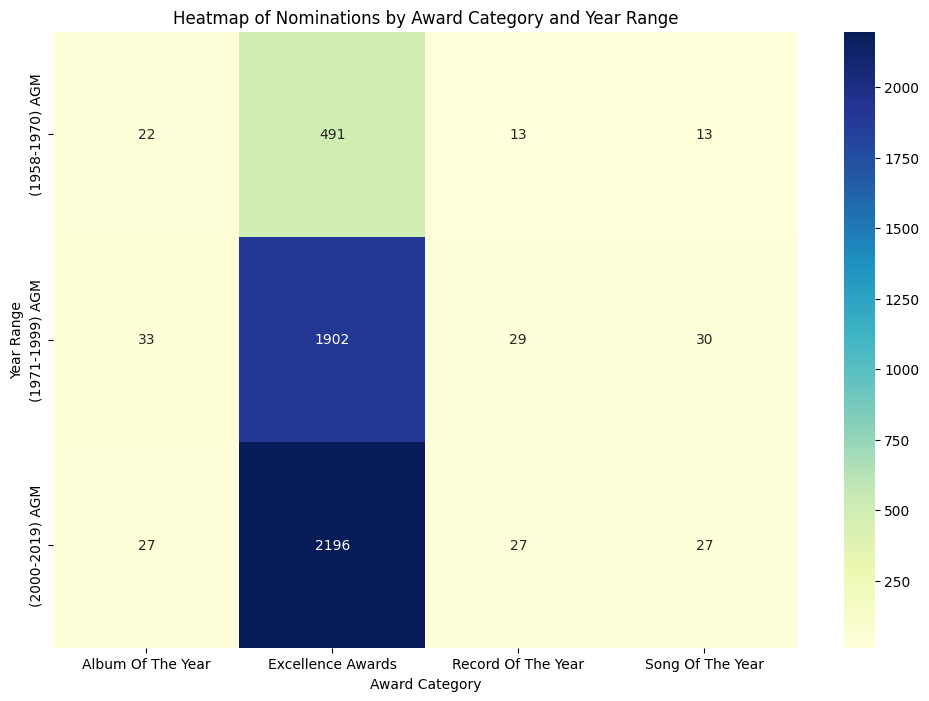

In [78]:
category_year_heatmap = pd.crosstab(df['title_by_year'], df['awards_group'])

plt.figure(figsize=(12, 8))
sns.heatmap(category_year_heatmap, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Nominations by Award Category and Year Range')
plt.xlabel('Award Category')
plt.ylabel('Year Range')
plt.show()


C:\Users\juanj\AppData\Local\Temp\ipykernel_18672\2425404620.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yearly_nominations = df.groupby('title_by_year').size()


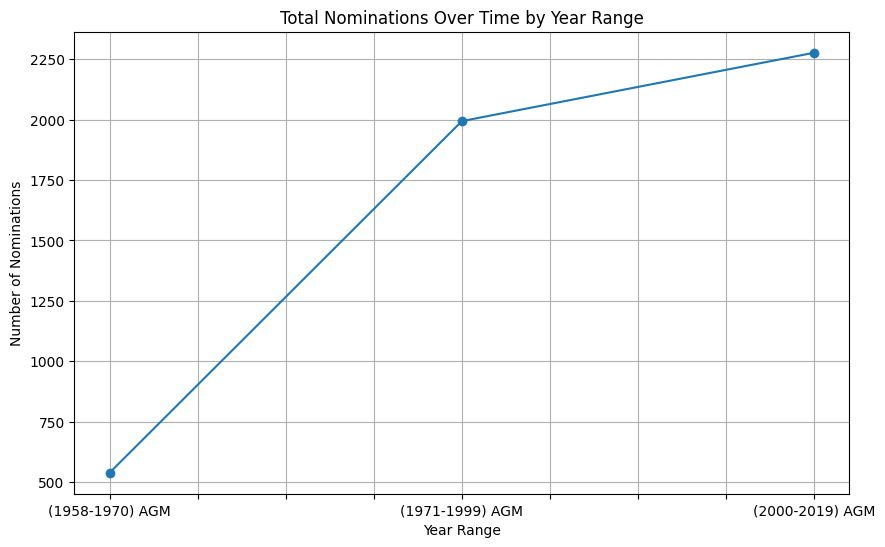

In [79]:
yearly_nominations = df.groupby('title_by_year').size()

yearly_nominations.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Total Nominations Over Time by Year Range')
plt.ylabel('Number of Nominations')
plt.xlabel('Year Range')
plt.grid(True)
plt.show()

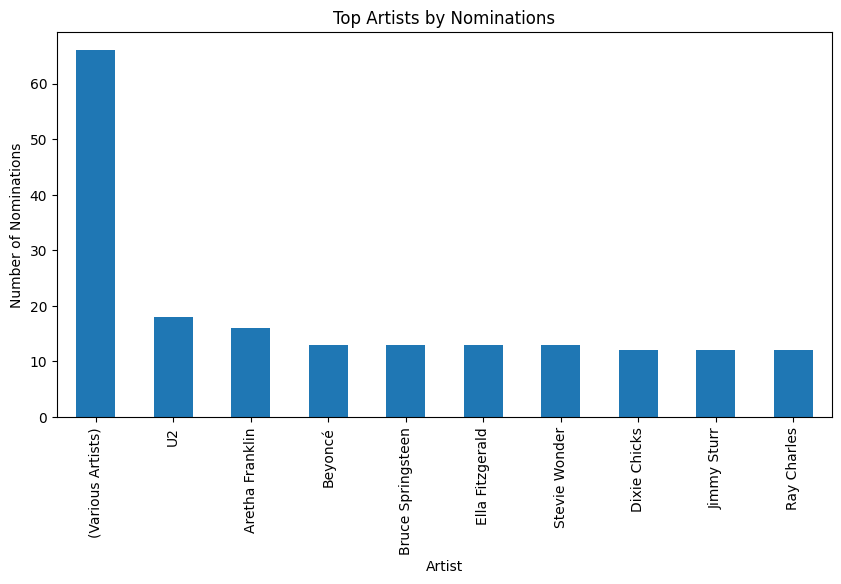

In [80]:
artist_nominations_total = df.groupby('artist')['title_by_year'].count().nlargest(10)  # Adjust to show more or fewer artists.

artist_nominations_total.plot(kind='bar', figsize=(10, 5))
plt.title('Top Artists by Nominations')
plt.ylabel('Number of Nominations')
plt.xlabel('Artist')
plt.show()

C:\Users\juanj\AppData\Local\Temp\ipykernel_18672\2960523322.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nominations_by_year = df.groupby('title_by_year').size()


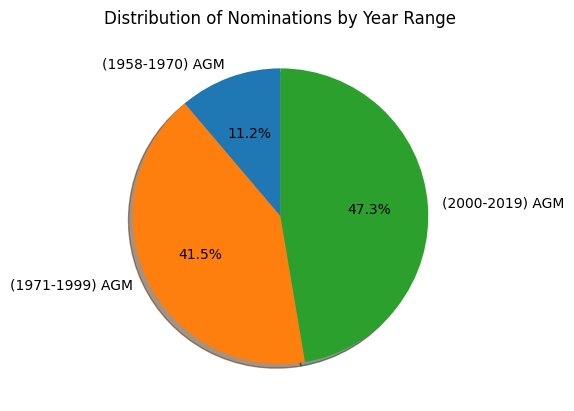

In [81]:
nominations_by_year = df.groupby('title_by_year').size()

nominations_by_year.plot(kind='pie', autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Distribution of Nominations by Year Range')
plt.ylabel('')
plt.show()

To conclude, the original with no modifications dataframe will be saved in a CSV file, which will then be used to begin merging and subsequently pass to Airflow.

In [82]:
df_grammys.to_csv('../data/grammys_to_merge.csv', index=False)